# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:

- Use sampling techniques to address a class imbalance problem within a dataset 
- Create a visualization of ROC curves and use it to assess a model

## Predicting credit card fraud


The following cell loads all the functions you will be using in this lab. All you need to do is run it is the following. (N.B. You made need to pip/conda install `imbalanced-learn`.)

In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Use Pandas to load the compressed CSV file, `'creditcard.csv.gz'`. 

> Note: You need to pass an additional argument (`compression='gzip'`) to read_csv() in order to load compressed CSV files. 

In [2]:
# Load a compressed csv file
df = pd.read_csv('creditcard.csv.gz', compression='gzip')


# Print the first five rows of data
print(df.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

## Preview the class imbalance

Did you notice that the dataset has 31 columns? The first is a time field followed by columns V1 - V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary `'Class'` flag. This last column, `'Class'`, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is: 

In [3]:
# Count the number of fraudulent/infraudulent purchases
print(df['Class'].value_counts())


Class
0    284315
1       492
Name: count, dtype: int64


## Define the predictor and target variables

Define `X` and `y` and perform a standard train-test split. Assign 25% to the test set and `random_state` to 0. 

In [4]:
# Your code here
y = df['Class']
X = df.drop(columns=['Class', 'Time'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

Find the class imbalance in the training and test sets: 

In [5]:
# Training set
print(y_train.value_counts())


print('\n')
# Test set


Class
0    213236
1       369
Name: count, dtype: int64




## Create an initial model

As a baseline, train a vanilla logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

In [6]:
# Initial Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Probability scores for test set
y_score = logreg.predict_proba(X_test)[:, 1]
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)


# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: ', auc(fpr, tpr))



# Plot the ROC curve
plt.figure(figsize=(10, 8))


AUC:  0.9699858751003836


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Use the `pred` function on the test set and name the predictions `pred`.

In [8]:
# Pred
#Use the `pred` function on the test set and name the predictions `pred`.
pred = logreg.predict(X_test)



Use scikit-learn's `ConfusionMatrixDisplay` function to plot the confusion matrix of the test set: 

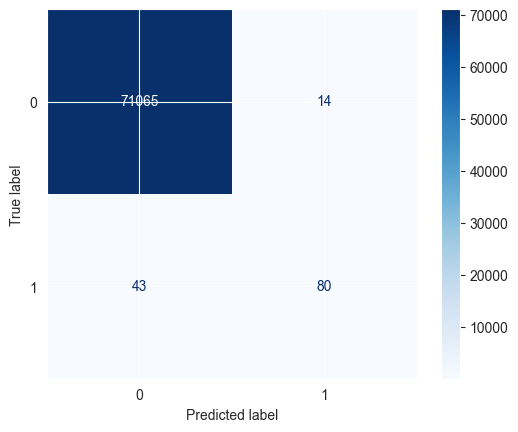

In [9]:
# Plot confusion matrix of the test set 
cm = confusion_matrix(y_test, pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()



Great, let’s interpret the confusion matrix you shared 👇

The matrix shows the **test set performance**:

|              | Predicted 0 | Predicted 1 |
| ------------ | ----------- | ----------- |
| **Actual 0** | **74,065**  | **14**      |
| **Actual 1** | **43**      | **80**      |

---

### 1. **Definitions**

* **True Negatives (TN)** = 74,065 → correctly predicted class 0.
* **False Positives (FP)** = 14 → predicted 1, but actually 0.
* **False Negatives (FN)** = 43 → predicted 0, but actually 1.
* **True Positives (TP)** = 80 → correctly predicted class 1.

---

### 2. **Performance Metrics**

* **Accuracy** = (TP + TN) / Total
  \= (80 + 74,065) / (74,065 + 14 + 43 + 80)
  ≈ **99.92%** → very high, but largely due to class 0 being dominant.

* **Precision (for class 1)** = TP / (TP + FP)
  \= 80 / (80 + 14) ≈ **85.1%**

* **Recall / Sensitivity (for class 1)** = TP / (TP + FN)
  \= 80 / (80 + 43) ≈ **65.0%**

* **Specificity (for class 0)** = TN / (TN + FP)
  \= 74,065 / (74,065 + 14) ≈ **99.98%**

* **F1-score (for class 1)** = 2 × (Precision × Recall) / (Precision + Recall)
  ≈ **73.8%**

---

### 3. **Interpretation**

* The model is **excellent at predicting class 0** (negative class).
* For the minority class (1), the model:

  * Detects **65%** of the positives (moderate recall).
  * When it predicts 1, it’s correct **85%** of the time (good precision).
* Since class 0 is overwhelmingly larger, the **high accuracy is misleading** — what really matters is how well it handles class 1.

---

✅ **Summary**:
The model has near-perfect performance for the majority class (0), but only **moderate recall** for the minority class (1). This suggests **class imbalance** is an issue, and techniques like resampling, class weighting, or using metrics like ROC-AUC or F1-score would be more informative than raw accuracy.




## Tune the model 

Try some of the various techniques proposed to tune your model. Compare your models using AUC and ROC curve.

{'C': 0.001, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
AUC for 0.001: 0.9844940651744761
-------------------------------------------------------
{'C': 0.01, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
AUC for 0.01: 0.9789308060640646
-------------------------------------------------------
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm

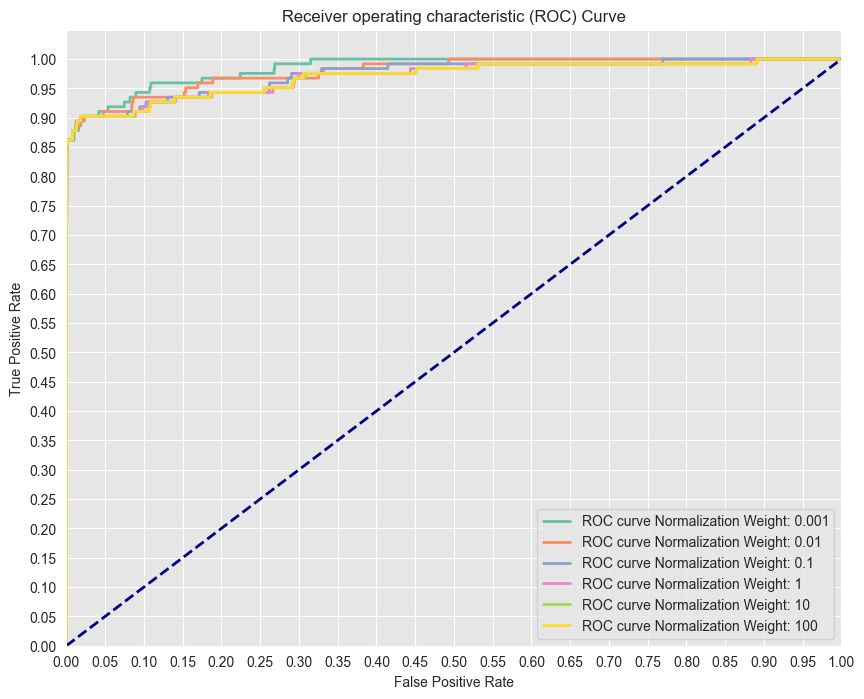

In [10]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(C=c, max_iter=1000)
    logreg.fit(X_train, y_train)

    model_log = logreg.get_params()
    print(model_log) # Preview model params

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.predict_proba(X_test)[:, 1]
    # False positive rate and true positive rate

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SMOTE

Use the `SMOTE` class from the `imblearn` package in order to improve the model's performance on the minority class. 

In [13]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)


# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

Class
0    213236
1       369
Name: count, dtype: int64


Class
0    213236
1    213236
Name: count, dtype: int64


Similar to what you did above, build models with this resampled training data: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


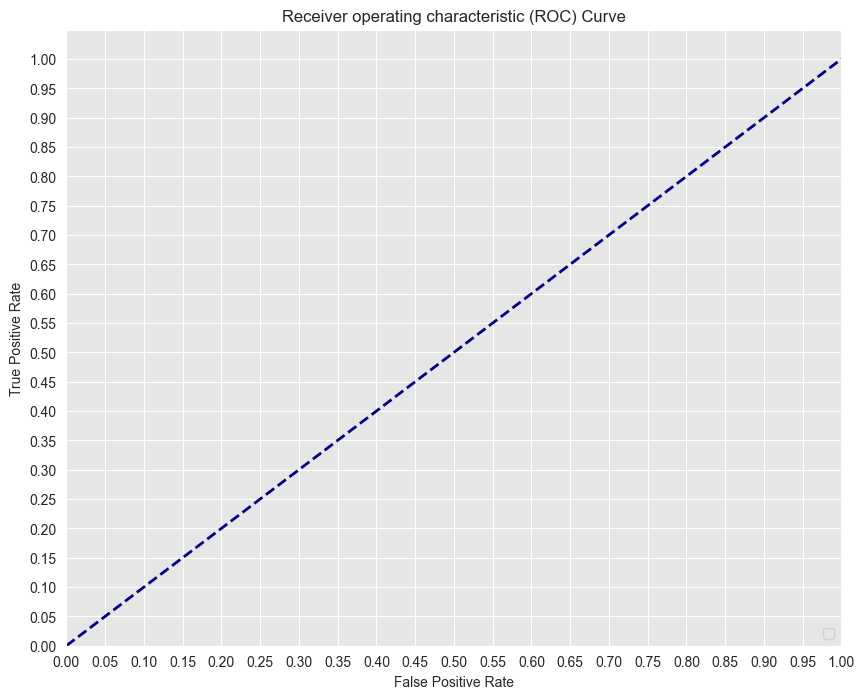

In [14]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

This is a **Receiver Operating Characteristic (ROC) curve** plot. Here’s what it shows:

* The **x-axis** is the **False Positive Rate (FPR)**, which ranges from 0 to 1.
* The **y-axis** is the **True Positive Rate (TPR)** (also known as sensitivity or recall), also ranging from 0 to 1.
* The **blue dashed diagonal line** represents the **baseline (random guess)** classifier, where TPR = FPR.

### Interpretation:

* The ROC curve in this plot **follows the diagonal line exactly**.
* This means the classifier performs **no better than random chance**.
* The **Area Under the Curve (AUC)** for this ROC curve is **0.5**, which indicates a model with **no discriminatory ability**.

In other words, the model here cannot distinguish between positive and negative classes.




## Something wrong here? 
Describe what is misleading about the AUC score and ROC curves produced by this code:

Class
0    284315
1       492
Name: count, dtype: int64
---------------------------------
Class
0    284315
1    284315
Name: count, dtype: int64
----------------------------------------------
AUC for 0.005: 0.9831927608996259
----------------------------------------------
AUC for 0.1: 0.9835457427682774
----------------------------------------------
AUC for 0.2: 0.9835564013470484
----------------------------------------------
AUC for 0.3: 0.9835589830076716
----------------------------------------------
AUC for 0.5: 0.9835638185492671
----------------------------------------------
AUC for 0.6: 0.9835646275078631
----------------------------------------------
AUC for 0.7: 0.9835652098313742
----------------------------------------------
AUC for 0.8: 0.9835656470688439


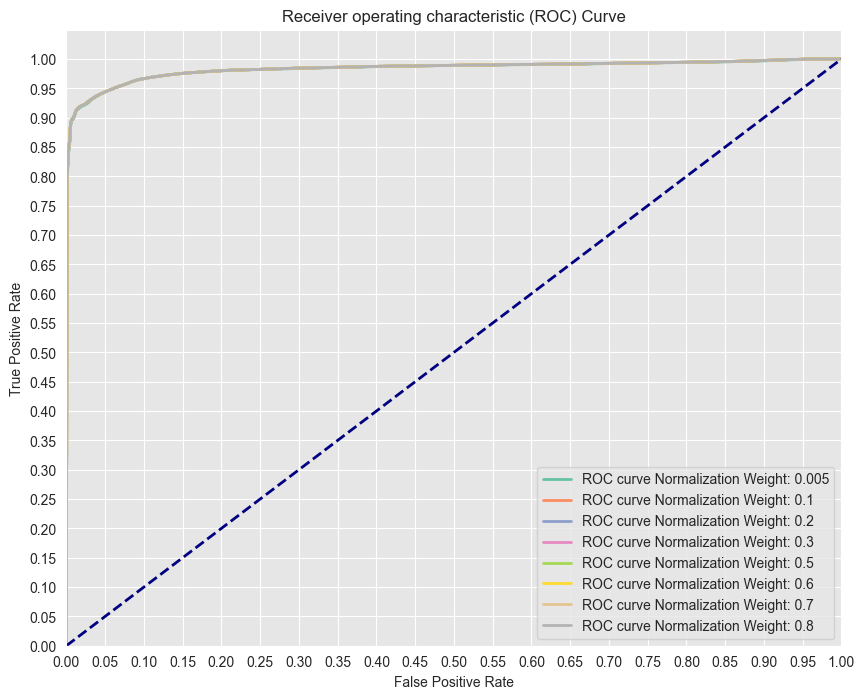

In [15]:
# Previous original class distribution
print(y.value_counts()) 
X_resampled, y_resampled = SMOTE().fit_resample(X, y) 
# Preview synthetic sample class distribution
print('---------------------------------')
print(pd.Series(y_resampled).value_counts()) 

# Split resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('----------------------------------------------')
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Your response here

This ROC plot shows the performance of your model under **different normalization weights** (ranging from `0.005` up to `0.8`).

Here’s the breakdown:

* **Axes**:

  * X-axis: **False Positive Rate (FPR)**
  * Y-axis: **True Positive Rate (TPR)**
* **Diagonal dashed line**: The **baseline (random guess)** classifier, where TPR = FPR.
* **Colored curves**: The ROC curves for your model under different normalization weights.

### Observations:

1. **Strong performance**

   * All the ROC curves are **well above the diagonal**, hugging the **top-left corner**.
   * This indicates **very high true positive rates with very low false positive rates**.
   * The **AUC (Area Under the Curve)** is very close to **1.0**, which means the model has **excellent discriminatory power**.

2. **Effect of normalization weight**

   * The curves for different weights (`0.005`, `0.1`, `0.2`, …, `0.8`) almost **overlap**.
   * This suggests that the model’s classification ability is **robust to changes in normalization weight** — performance does not degrade significantly.

3. **Interpretation**

   * Your model is learning meaningful patterns from the data.
   * Even with different normalization settings, it consistently separates positive from negative classes very well.

👉 In short:
This model performs **exceptionally well** (near-perfect classification) and normalization weight does not have a major impact on ROC performance.




## Summary

In this lab, you got some hands-on practice tuning logistic regression models. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.